In [1]:
!pip3 install -U segmentation-models
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import tensorflow as tf
tf.keras.backend.set_image_data_format('channels_last')

/bin/bash: /home/nastiag67/miniconda3/envs/tumour_segmentation_wsl_39/lib/libtinfo.so.6: no version information available (required by /bin/bash)
env: SM_FRAMEWORK=tf.keras


2023-04-09 23:55:41.061099: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-09 23:55:41.099773: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 23:55:41.859739: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Segmentation Models: using `tf.keras` framework.


In [2]:
import sys
import os
import glob
import random
import time

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from segmentation_models import Unet, Linknet, PSPNet, FPN
import keras
from segmentation_models.utils import set_trainable
from torch.utils.data import Dataset

In [3]:
# Path to all data
DATA_PATH = "./kaggle/input/lgg-mri-segmentation/kaggle_3m/"

# File path line length images for later sorting
BASE_LEN = 89 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_ <-!!!43.tif)
END_IMG_LEN = 4 # len(/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->.tif)
END_MASK_LEN = 9 # (/kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_43 !!!->_mask.tif)

# img size
IMG_SIZE = 256

In [4]:
# Raw data
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    print(sub_dir_path)
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

./kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
This is not a dir: ./kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv
./kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
This is not a dir: ./kaggle/input/lgg-mri-segmentation/kaggle_3m/README.md
./kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909
./kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4942_19970222
./kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902
./kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4944_20010208
./kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606
./kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19981004
./kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5396_20010302
./kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315
./kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6186_20000601
./kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812
./kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6290_2

,dirname,path
0,TCGA_CS_4941_19960909,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...
1,TCGA_CS_4941_19960909,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...
2,TCGA_CS_4941_19960909,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...
3,TCGA_CS_4941_19960909,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...
4,TCGA_CS_4941_19960909,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...


In [5]:
print("Dataframe Size: ", len(df))

Dataframe Size:  7858


In [6]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : x[BASE_LEN:-END_IMG_LEN])
masks = sorted(df_masks["path"].values, key=lambda x : x[BASE_LEN:-END_MASK_LEN])

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: ./kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_13.tif 
Path to the Mask: ./kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_13_mask.tif


In [7]:
print("length of images: ", len(df_imgs))
print("length of masks: ", len(df_masks))

length of images:  3929
length of masks:  3929


In [8]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

,patient,image_path,mask_path,diagnosis
0,TCGA_CS_4941_19960909,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,0
1,TCGA_CS_4941_19960909,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,0
2,TCGA_CS_4941_19960909,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,0
3,TCGA_CS_4941_19960909,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,0
4,TCGA_CS_4941_19960909,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,0
...,...,...,...,...
3924,TCGA_HT_A61B_19991127,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,1
3925,TCGA_HT_A61B_19991127,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,0
3926,TCGA_HT_A61B_19991127,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,0
3927,TCGA_HT_A61B_19991127,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,./kaggle/input/lgg-mri-segmentation/kaggle_3m/...,0


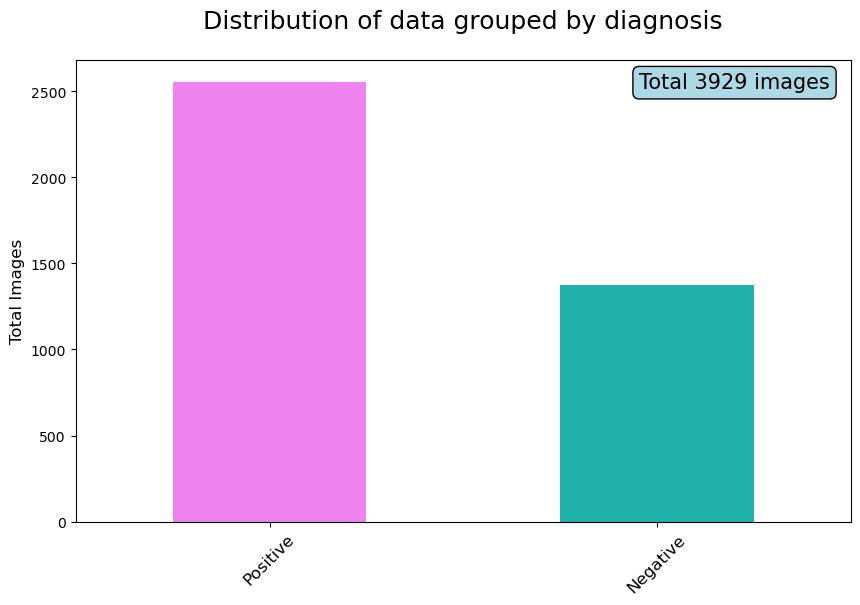

In [9]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

In [10]:
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    #image = crop_image_from_gray(image)
    #image=cv2.addWeighted(image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

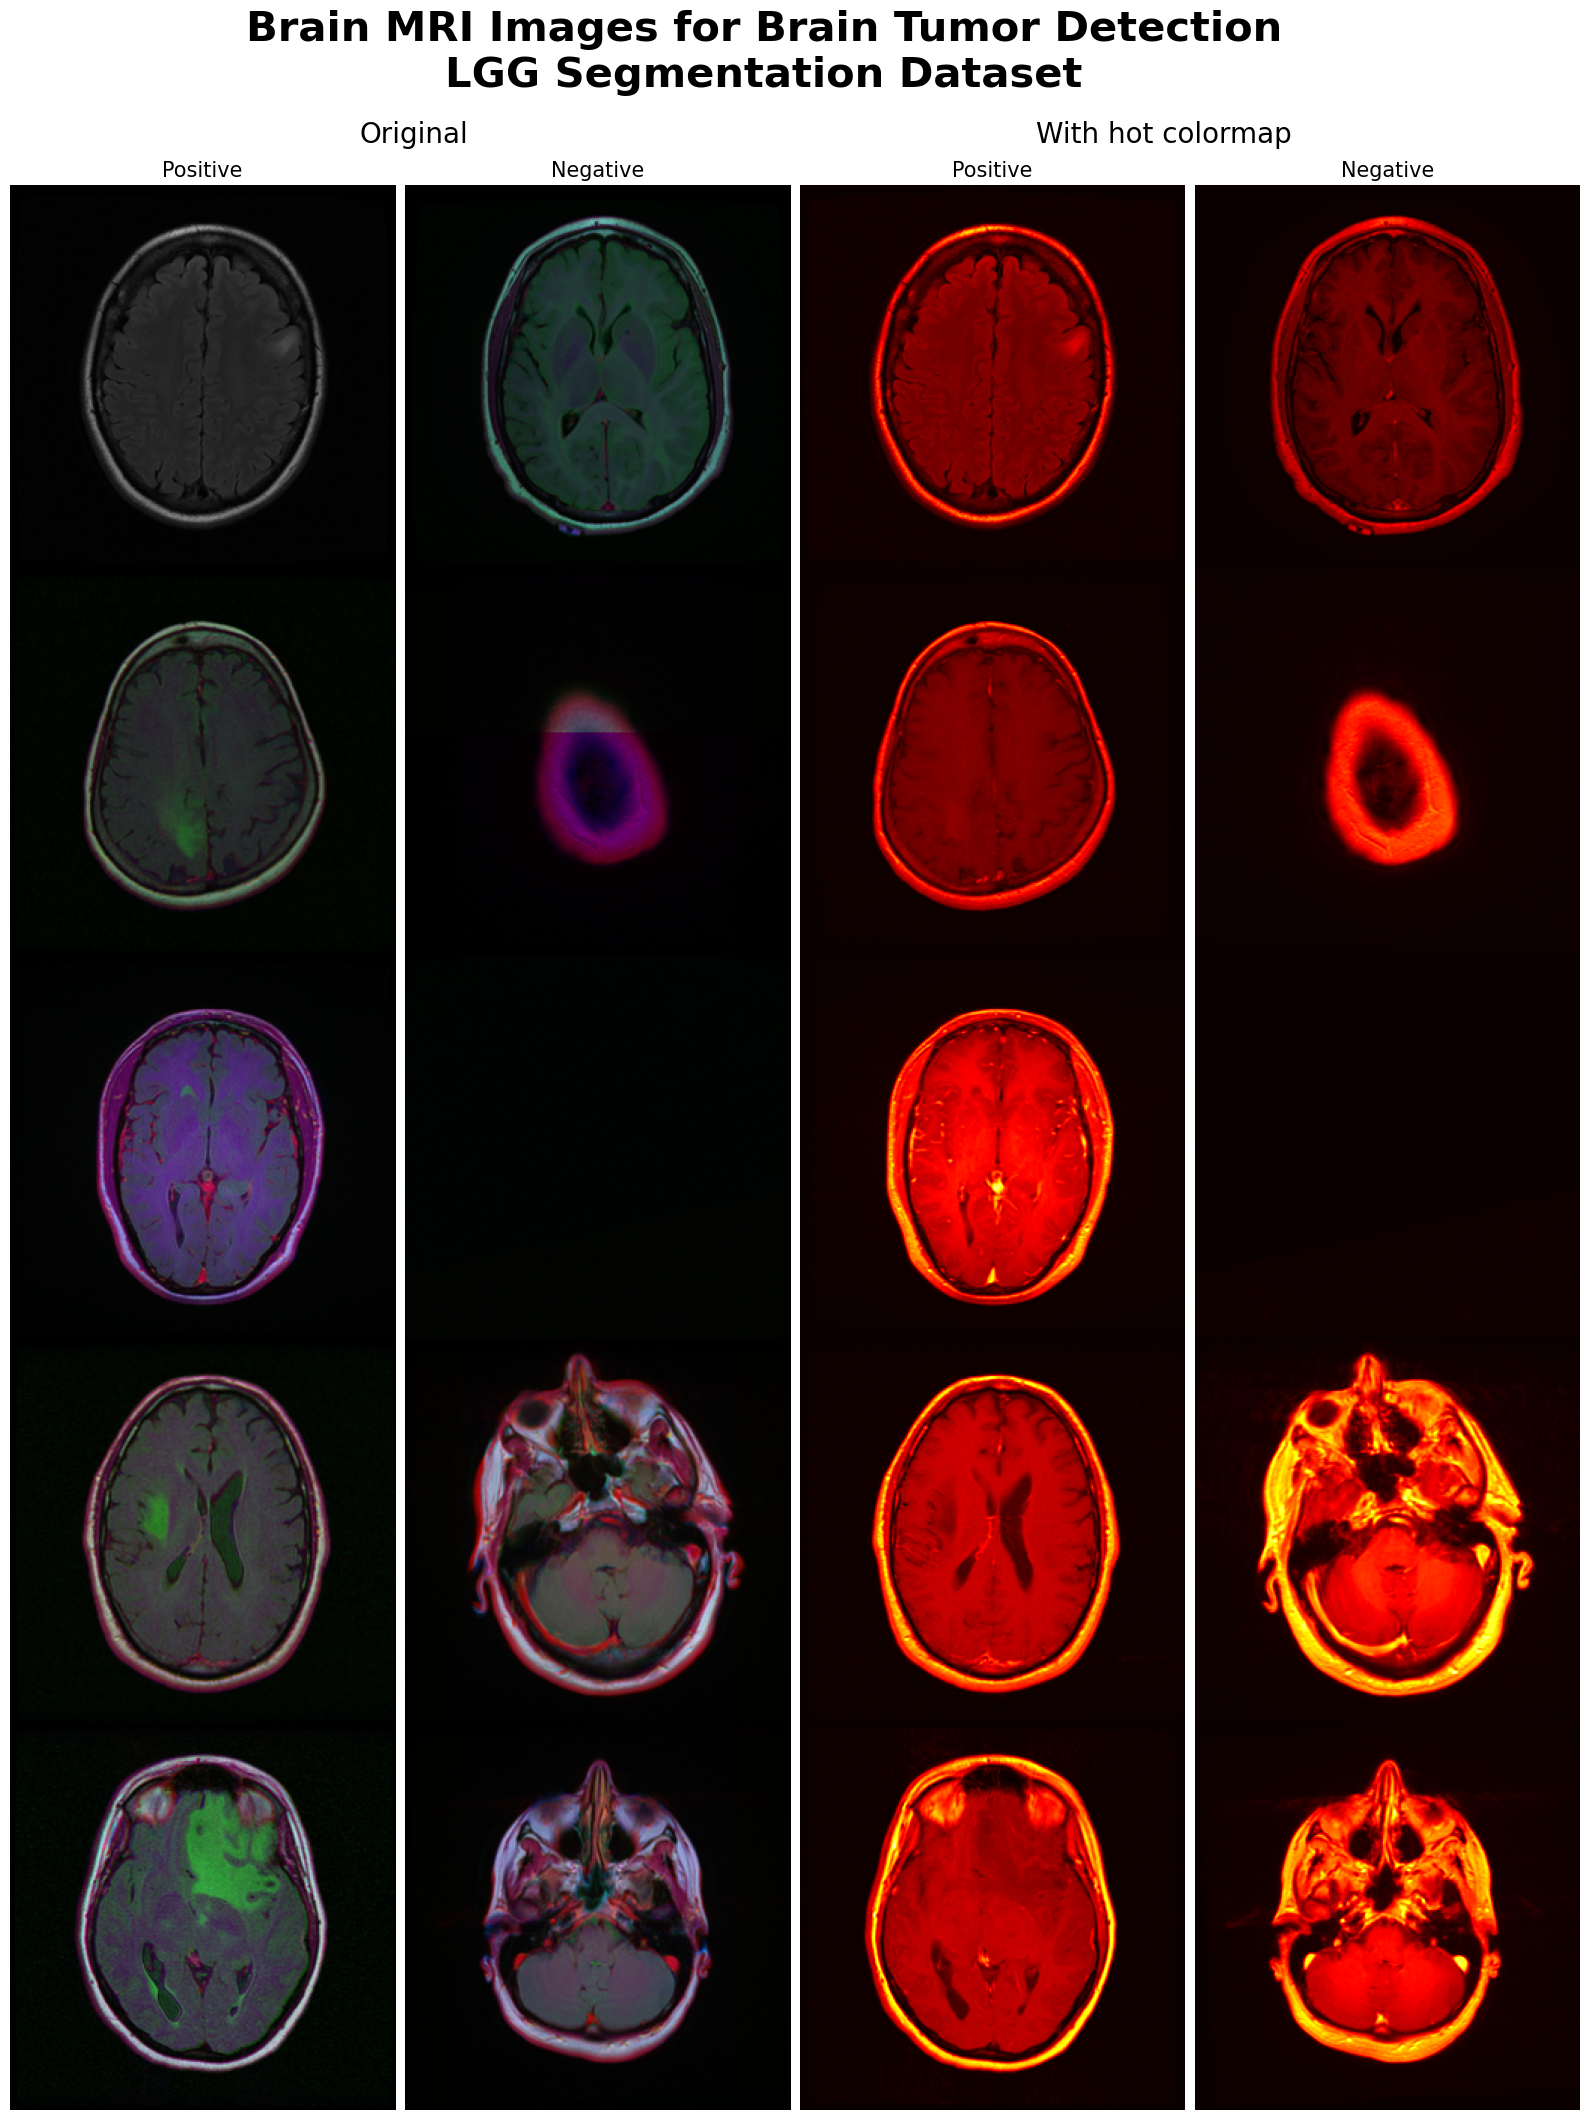

In [11]:
# Data
sample_yes_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

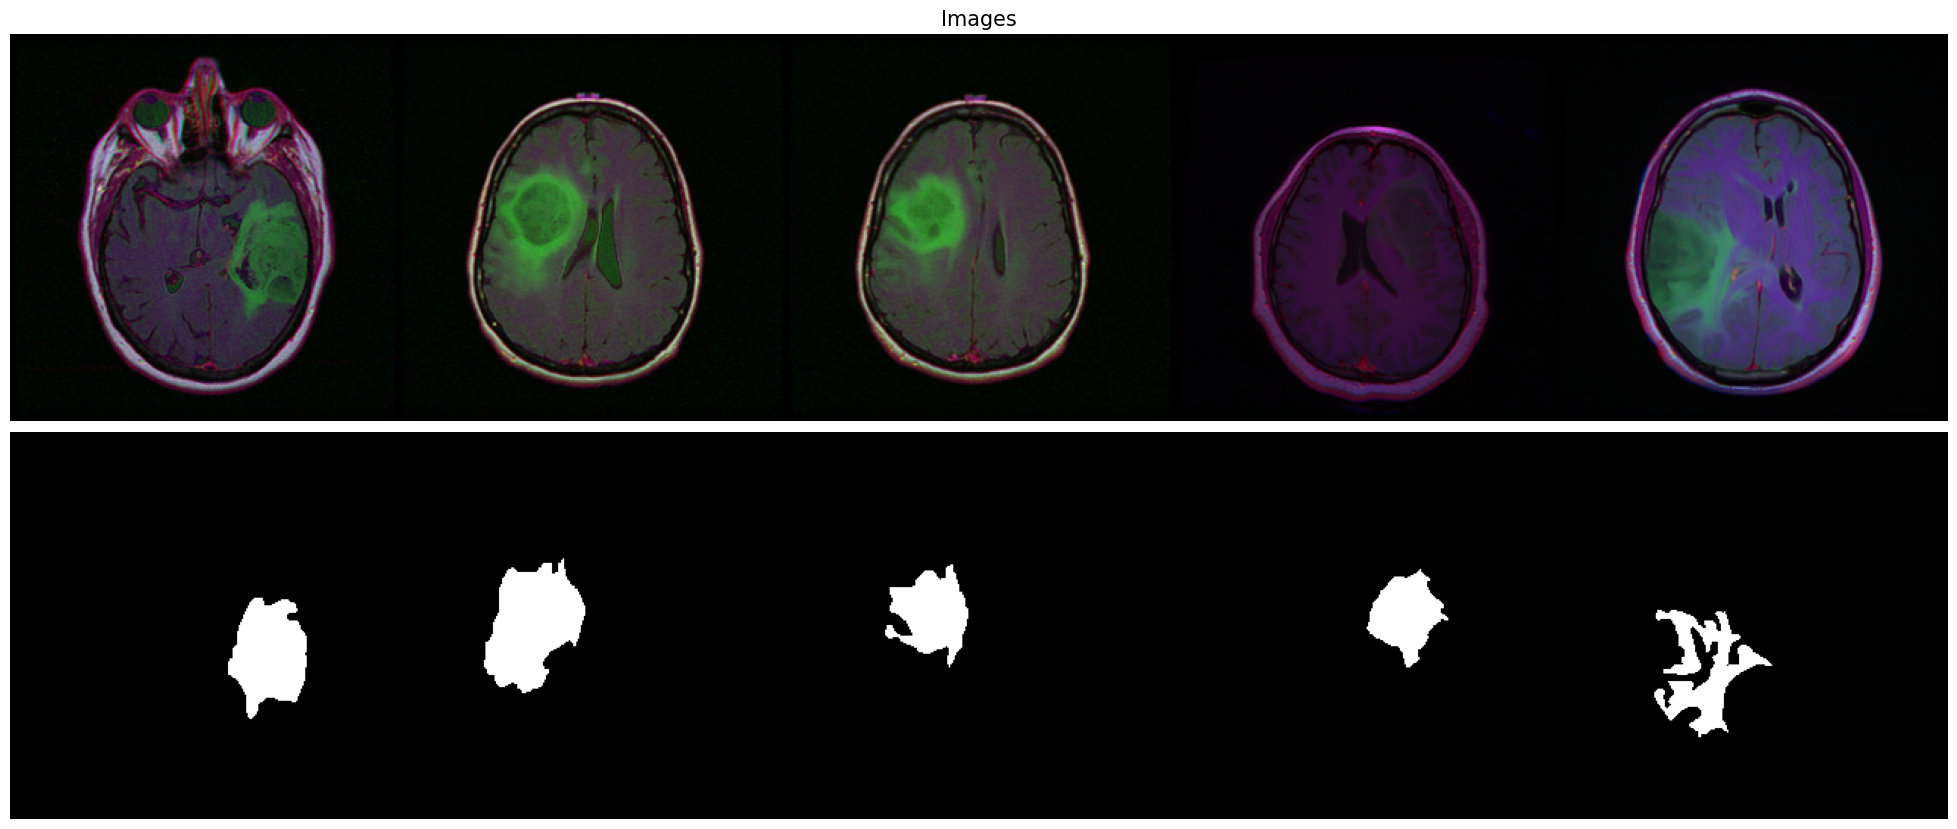

In [12]:
# Data
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = load_ben_color(data[1])
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()

In [13]:
# Split df into train_df and val_df
train_df, val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1, shuffle=True)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Split train_df into train_df and test_df
train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.15)
train_df = train_df.reset_index(drop=True)

#train_df = train_df[:1000]
print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3005, 4) 
Val: (393, 4) 
Test: (531, 4)


In [14]:
def normalizing(img):
    norm = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return norm

In [15]:
!nvidia-smi

/bin/bash: /home/nastiag67/miniconda3/envs/tumour_segmentation_wsl_39/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Apr  9 23:58:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.41.03              Driver Version: 531.41       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3070 T...    On | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P5               18W /  N/A|   1492MiB /  8192MiB |     11%      Default |
|           

In [16]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch.transforms import ToTensor

In [17]:
PATCH_SIZE = 256

strong_transforms = A.Compose([
    A.RandomResizedCrop(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    
    # Pixels
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.25),
    A.Emboss(p=0.25),
    A.Blur(p=0.01, blur_limit = 3),
    
    # Affine
    A.OneOf([
        A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(p=1, distort_limit=2, shift_limit=0.5)                  
    ], p=0.8),
    
    
    A.Normalize(p=1.0),
    #https://albumentations.readthedocs.io/en/latest/api/pytorch.html?highlight=ToTensor#albumentations.pytorch.transforms.ToTensor
    ToTensorV2(),
])


transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),

    
    
    #A.Normalize(p=1.0),
])

In [18]:
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        # newer version of tf/keras want batch to be in tuple rather than list
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [19]:
class BrainMriDataset(Dataset):
    def __init__(self, df, transforms, preprocessing=None):
        
        self.df = df
        self.transforms = transforms
        self.preprocessing = preprocessing
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = load_ben_color(self.df.iloc[idx, 1])
        mask = cv2.imread(self.df.iloc[idx, 2], 0)
        mask = normalizing(mask)
        
        if self.preprocessing:
            image = self.preprocessing(image)
            
        augmented = self.transforms(image=image, 
                                    mask=mask)
 
        image = augmented['image']
        mask = augmented['mask']
        
        
        
        return image, mask

In [20]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [21]:
#BACKBONE = 'inceptionv3'
#BACKBONE = 'seresnext50'
BACKBONE = 'densenet121'
preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 # case for binary and multiclass segmentation
activation = 'sigmoid'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_weights=None, encoder_freeze=True)

# define optomizer
optim = keras.optimizers.Adam(0.001)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
#dice_loss = sm.losses.DiceLoss()
#focal_loss = sm.losses.BinaryFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)

2023-04-09 23:58:57.347932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-09 23:58:57.434152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-09 23:58:57.434213: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-09 23:58:57.437777: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-09 23:58:57.437854: I tensorflow/compile

In [22]:
#tf.keras.utils.plot_model(
#    model, to_file='model.png', show_shapes=False, show_dtype=False,
#    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)


In [23]:
# train
train_dataset = BrainMriDataset(df=train_df, transforms=transforms, preprocessing=preprocess_input)
train_dataloader = Dataloder(train_dataset, batch_size=26, shuffle=True)

# val
val_dataset = BrainMriDataset(df=val_df, transforms=transforms, preprocessing=preprocess_input)
val_dataloader = Dataloder(val_dataset, batch_size=26, shuffle=True)

#test
test_dataset = BrainMriDataset(df=test_df, transforms=transforms, preprocessing=preprocess_input)
test_dataloader = Dataloder(test_dataset, batch_size=26, shuffle=True)

In [24]:
#model.summary()

In [25]:
# train model
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=200, 
    validation_data=val_dataloader, 
    validation_steps=len(val_dataloader),
)

Epoch 1/200


2023-04-09 23:59:05.407774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


: 

: 

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

In [ ]:
model.save_weights("weights-BrainMriSegmentation-UNet+InceptionV3.hdf5")

In [ ]:
np.save('UNet+InceptionV3_history.npy',history.history)

In [ ]:
n = 5
ids = np.random.choice(np.arange(len(test_dataset)), size=n)

for i in ids:
    
    image, gt_mask = test_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=image.squeeze(),
        gt_mask=gt_mask.squeeze(),
        pr_mask=pr_mask.squeeze(),
    )